# Imports

In [2]:
from __future__ import annotations

%matplotlib inline
import git
import copy
import glob
import os
import random
import warnings
from argparse import ArgumentParser
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
from collections import Counter
from copy import copy
from pathlib import Path
from contextlib import redirect_stdout
import io

import matplotlib.pyplot as plt
import pyrootutils
import neptune.new as neptune
import numpy as np
import pytorch_lightning as pl
# torch and lightning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from neptune.new.types import File
from PIL import Image, ImageEnhance
from pytorch_lightning.callbacks.finetuning import BaseFinetuning
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.utilities.rank_zero import rank_zero_info
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchmetrics import Accuracy, ConfusionMatrix
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import _log_api_usage_once


# Settings

In [3]:

# Ensure that all operations are deterministic for reproducibility
seed = 42
pl.seed_everything(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)

Global seed set to 42


# Class and method definitions

### General-purpose

In [4]:
def pad(spectrogram: np.ndarray, pad_length: int) -> np.ndarray:
    """
    Centre pads an RGB spectrogram to a given length.

    Args:
        spectrogram (np.ndarray): Spectrogram to pad.
        pad_length (int): Full length of padded spectrogram

    Returns:
        np.ndarray: Padded spectrogram
    """
    spec_shape = np.shape(spectrogram)
    excess_needed = pad_length - spec_shape[1]
    pad_left = int(np.floor(float(excess_needed) / 2))
    pad_right = int(np.ceil(float(excess_needed) / 2))
    padded_spec = np.full((spec_shape[0], pad_length, 3), np.min(spectrogram))
    padded_spec[:, pad_left : pad_length - pad_right, :] = spectrogram
    return padded_spec


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

### Data augmentation classes

### Custom transformations

In [5]:
class TimeCrop(torch.nn.Module):
    """
    Crops the given image at a random point in the time domain
    greater than its height and smaller than its maximum
    length minus its height.

    Note:
        Does not work with tensors.
    """

    def __init__(self):
        super().__init__()
        _log_api_usage_once(self)

    def forward(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.

        Returns:
            PIL Image: Cropped image.
        """
        img = np.asarray(img)
        H, W = img.shape[:2]
        if W < H:
            # Pads adding some extra width
            # so that the img is not always
            # in the same position
            img = pad(img, int(H + H * 0.25))

        H, W = img.shape[:2]
        r_idx = random.randint(0, W - H)
        img = img[:, r_idx : r_idx + H]
        return Image.fromarray(img)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class ChangeBrightness(torch.nn.Module):
    """
    Changes the brightness by a factor drawn from a uniform
    distribution between provided numbers.

    Args:
        factor (tuple): A tuple containing a range of
            brightness (e.g. 0.5 means 50% brightness).
        p (float): Probability with which the
            transformation will be applied.

    Warning:
        Does not work with tensors.

    """

    def __init__(self, factor: tuple = (0.9, 1.6), p: float = 0.5):
        super().__init__()
        _log_api_usage_once(self)
        self.factor = factor
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image): Image to be modified.

        Returns:
            PIL Image: Modified image.
        """
        if self.p < torch.rand(1):
            return img
        f = random.uniform(self.factor[0], self.factor[1])
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(f)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(factor={self.factor}, p={self.p})"


### Train/val/test transformations

In [6]:
class ImgTransform:
    def __init__(
        self,
        img_size=224,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
        self.stage = {
            "train": T.Compose(
                [
                    TimeCrop(),
                    T.RandomRotation(degrees=(-1, 1)),
                    T.RandomAdjustSharpness(sharpness_factor=6, p=0.2),
                    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.005, 4)),
                    ChangeBrightness(factor=(0.8, 1.6), p=0.5),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                    T.RandomErasing(
                        p=0.2, scale=(0.02, 0.05), ratio=(0.3, 3.3)
                    ),
                ]
            ),
            "validate": T.Compose(
                [
                    TimeCrop(),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                ]
            ),
            "test": T.Compose(
                [
                    TimeCrop(),
                    T.ToTensor(),
                    # T.Normalize(mean, std),
                ]
            ),
        }


### Define data module

In [76]:
class GreatTitDataModule(pl.LightningDataModule):
    def __init__(self, train_path, test_path, batch_size=16, seed=42):
        super().__init__()
        self.batch_size = batch_size
        self.train_path = train_path
        self.test_path = test_path
        self.seed = seed

    def setup(self, stage=None):

        # Load and split training set
        d = ImageFolder(self.train_path)

        # Prepare weighted sampler for training data (oversample)
        class_count = Counter(d.targets)
        class_weights = torch.Tensor(
            [
                len(d.targets) / c
                for c in pd.Series(class_count).sort_index().values
            ]
        )

        sample_weights = [0] * len(d)
        for idx, (image, label) in enumerate(d):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        self.train_sampler = WeightedRandomSampler(
            weights=sample_weights, num_samples=len(d), replacement=True
        )

        # Stratified split for validation
        train_idx, valid_idx = train_test_split(
            np.arange(len(d.targets)),
            test_size=0.3,
            shuffle=True,
            random_state=self.seed,
            stratify=d.targets,
        )

        # Prepare train/validation/test datasets
        self.train, self.validate = copy(d), copy(d)
        self.train.imgs = np.array(d.imgs)[train_idx].tolist()
        self.train.targets = np.array(d.targets)[train_idx].tolist()
        self.validate.imgs = np.array(d.imgs)[valid_idx].tolist()
        self.validate.targets = np.array(d.targets)[valid_idx].tolist()
        self.test = ImageFolder(self.test_path)
        # get all data (from train and  test folders ) by joining validate and test

        self.all = torch.utils.data.ConcatDataset([self.test, self.validate])

        # Transforms
        self.train.transform = ImgTransform().stage["train"]
        self.validate.transform = ImgTransform().stage["validate"]
        self.test.transform = ImgTransform().stage["test"]
        self.all.transform = ImgTransform().stage["test"]

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            sampler=self.train_sampler,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validate,
            batch_size=100,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=100,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
        )

    def predict_dataloader(self):
        # load all the data (from train, validate and test) using test time
        # image augmentation
        return DataLoader(
            self.all,
            batch_size=256,
            shuffle=True,
            num_workers=10,
            pin_memory=True,
        )


### Fine tuning module

In [77]:
# See [1] for more details on the training regime:

class MilestonesFinetuning(BaseFinetuning):
    def __init__(self, milestones: tuple = (5, 10), train_bn: bool = False):
        super().__init__()
        self.milestones = milestones
        self.train_bn = train_bn

    def freeze_before_training(self, pl_module: pl.LightningModule):
        self.freeze(modules=pl_module.feature_extractor, train_bn=self.train_bn)

    def finetune_function(
        self,
        pl_module: pl.LightningModule,
        epoch: int,
        optimizer: Optimizer,
        opt_idx: int,
    ):
        if epoch == self.milestones[0]:
            # unfreeze 5 last layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[-5:],
                optimizer=optimizer,
                train_bn=self.train_bn,
            )

        elif epoch == self.milestones[1]:
            # unfreeze remaining layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[:-5],
                optimizer=optimizer,
                train_bn=self.train_bn,
            )

### Main model module

In [78]:
logg_params = {
    "on_step": True,
    "on_epoch": True,
    "prog_bar": True,
    "logger": True,
}

class ResNetClassifier(pl.LightningModule):
    def __init__(
        self,
        num_classes: int | None = None,
        backbone: str = "resnet50",
        train_bn: bool = False,
        batch_size: int = 16,
        transfer=True,
        milestones: tuple = (2, 4),
        lr: float = 1e-3,
        lr_scheduler_gamma: float = 1e-1,
    ):
        super().__init__()

        self.__dict__.update(locals())
        self.num_classes = num_classes
        self.backbone = backbone
        self.transfer = transfer = (True,)
        self.lr = lr
        self.milestones = milestones
        self.lr_scheduler_gamma = lr_scheduler_gamma
        self.batch_size = batch_size

        self.__build_model()

        self.train_acc = Accuracy()
        self.valid_acc = Accuracy()
        self.test_acc = Accuracy()
        self.save_hyperparameters()

        self.val_confusion = ConfusionMatrix(num_classes=self.num_classes)
        self.test_confusion = ConfusionMatrix(num_classes=self.num_classes)

    def __build_model(self):
        """Define model layers & loss."""

        # 1. Load pre-trained network:
        model_func = getattr(models, self.backbone)
        self.backbone = model_func(pretrained=self.transfer)

        _layers = list(self.backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*_layers)
        linear_size = list(self.backbone.children())[-1].in_features

        # 2. Classifier:
        # _fc_layers = [nn.Linear(2048, 1000), nn.ReLU(), nn.Linear(1000, self.num_classes)]
        # self.backbone.fc = nn.Sequential(*_fc_layers)
        self.backbone.fc = nn.Linear(linear_size, self.num_classes)

        # 3. Loss:
        self.loss_func = (
            nn.BCEWithLogitsLoss()
            if self.num_classes == 2
            else nn.CrossEntropyLoss()
        )

    def forward(self, x):
        return self.backbone(x)

    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainab_params = list(filter(lambda p: p.requires_grad, parameters))
        rank_zero_info(
            f"The model will start training with only {len(trainab_params)} "
            f"trainable parameters out of {len(parameters)}."
        )
        optimizer = optim.Adam(trainab_params, lr=self.lr)
        scheduler = MultiStepLR(
            optimizer, milestones=self.milestones, gamma=self.lr_scheduler_gamma
        )
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.train_acc(preds, y)
        self.log("train/loss", loss, **logg_params)
        self.log("train/acc", self.train_acc, **logg_params)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.train_acc(preds, y)
        self.log("val/loss", loss, **logg_params)
        self.log("val/acc", self.train_acc, **logg_params)
        self.val_confusion.update(preds, batch[1])

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        loss = self.loss_func(preds, y)
        self.test_acc(preds, y)
        self.log("test/loss", loss, **logg_params)
        self.log("test/acc", self.test_acc, **logg_params)
        self.test_confusion.update(preds, batch[1])

        # Save wrong prediction images
        y_true = y.cpu().detach().numpy()
        y_pred = preds.argmax(axis=1).cpu().detach().numpy()

        for j in np.where(np.not_equal(y_true, y_pred))[0]:
            img = np.squeeze(x[j].cpu().detach().numpy())
            img[img < 0] = 0
            img = img / np.amax(img)
            labs = list(
                self.trainer.datamodule.val_dataloader().dataset.class_to_idx.keys()
            )
            neptune_logger.experiment["test/misclassified_images"].log(
                neptune.types.File.as_image(img.transpose((1, 2, 0))),
                description=f"y_pred = {labs[y_pred[j]]}, y_true = {labs[y_true[j]]}",
            )
            
    def predict_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        y_true = y.cpu().detach().numpy()
        y_pred = preds.argmax(axis=1).cpu().detach().numpy()
        return y_true, y_pred

    # Output graphs and extra metrics
    def plot_conf_matrix(self, conf_mat):
        labs = (
            self.trainer.datamodule.val_dataloader().dataset.class_to_idx.keys()
        )
        df_cm = pd.DataFrame(conf_mat, index=labs, columns=labs)
        plt.figure(figsize=(13, 10))
        fig_ = sns.heatmap(
            df_cm, annot=True, cmap="magma", fmt="g"
        ).get_figure()
        plt.close(fig_)
        return fig_

    def validation_epoch_end(self, outputs):
        conf_mat = (
            self.val_confusion.compute().detach().cpu().numpy().astype(np.int)
        )
        fig_ = self.plot_conf_matrix(conf_mat)
        self.logger.experiment["train/confusion_matrix"].log(
            File.as_image(fig_)
        )

    def test_epoch_end(self, outputs):
        conf_mat = (
            self.test_confusion.compute().detach().cpu().numpy().astype(np.int)
        )
        fig_ = self.plot_conf_matrix(conf_mat)
        self.logger.experiment["test/confusion_matrix"].log(File.as_image(fig_))


# Data ingest

In [79]:

# Project settings/directories
PROJECT_ROOT = pyrootutils.find_root()

data_path = PROJECT_ROOT / "resources" / "ML"
figures_path = PROJECT_ROOT / "reports" / "figures"
train_path, test_path = data_path / "train", data_path / "test"
n_classes = sum([1 for i in test_path.glob("**/")]) - 1


hparams = AttrDict(
    {
        "batch_size": 64,
        "num_classes": n_classes,
        "lr": 0.001,
        "lr_scheduler_gamma": 0.1,
        "milestones": (10, 15),
        "transfer": True,
        "train_bn": False,
    }
)

dm = GreatTitDataModule(
    train_path=train_path,
    test_path=test_path,
    batch_size=hparams.batch_size,
)

dm.setup()


In [68]:
n_classes

141

# Training

### Start logger and checkpoints

In [12]:
# To run this you will need neptune if you want to monitor model training,
# see [2] for more details.

# IMPORTANT: Load existing model? [None/model ID]
use_existing = "GRET-137"


def _init_neptune():
    run = neptune.init(
        project="nilomr/greti",
        flush_period=5,
        with_id=use_existing,
        mode="sync",  # async won't work in Oxford HPC
    )
    return run

def init_neptune_logger():
    try:
        return _init_neptune()
    except:
        try:
            return _init_neptune()
        except Exception as e:
            raise e

neptune_logger = NeptuneLogger(run=init_neptune_logger())

CHECKPOINTS_DIR = Path("checkpoints") / neptune_logger._run_short_id
model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    monitor="val/acc_epoch",
    mode="max",
    save_top_k=2,
    save_weights_only=True,
)

https://app.neptune.ai/nilomr/greti/e/GRET-137
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [13]:
#neptune_logger.run.stop()

## Instantiate model and trainer

In [80]:
model = ResNetClassifier(**hparams)

trainer = pl.Trainer(
    max_epochs=30,
    logger=neptune_logger,
    callbacks=[
        model_checkpoint,
        EarlyStopping(monitor="val/loss_epoch", mode="min", patience=4),
        MilestonesFinetuning(milestones=(5, 10), train_bn=hparams.train_bn),
    ],
    log_every_n_steps=1,
    accelerator="gpu",
    devices=1,
    precision=16, # If supported use 16-bit precision
    num_sanity_val_steps=0,  #FIXME #BUG @nilomr Validation gets stuck with full dataset
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train model

Skip this if you have already trained a model

In [15]:
# trainer.fit(model, dm)

# Test best model in held out (test) dataset

## Retrieve model

In [81]:
# best_model = ResNetClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
# If from fresh session:

lckpt = list(
    (
        Path(neptune_logger.save_dir).parent
        / "checkpoints"
        / neptune_logger._run_short_id
    ).glob("*ckpt")
)[-1]
best_model = ResNetClassifier.load_from_checkpoint(lckpt)

## Get model predictions for test set

In [17]:
# trainer.test(best_model, datamodule=dm)

In [135]:
trainer.callback_metrics

{}

# Predictions

In [82]:
predictions = trainer.predict(best_model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [142]:
from sklearn.metrics import classification_report

# Flatten the predictions
y_true = []
y_pred = []
for batch in predictions:
    y_true.extend(batch[0].tolist())
    y_pred.extend(batch[1].tolist())

# Get the real labels
class_to_idx = best_model.trainer.datamodule.val_dataloader().dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
target_names = [idx_to_class[label] for label in y_true]
target_names = list(
                best_model.trainer.datamodule.val_dataloader().dataset.class_to_idx.keys()
            )

# Get the classification report
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

In [137]:
report

{'00-N3-LH-UM-R3': {'precision': 0.9615384615384616,
  'recall': 1.0,
  'f1-score': 0.9803921568627451,
  'support': 25},
 '04-N3-R3': {'precision': 0.875,
  'recall': 0.9333333333333333,
  'f1-score': 0.9032258064516129,
  'support': 15},
 '05-N3-R3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12},
 '06-N4-R3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15},
 '07-N8-R3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15},
 '10-N3-R3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12},
 '122-N3-R2': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 24},
 '129-N5-R2': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 10},
 '130-N3-R2': {'precision': 0.9672131147540983,
  'recall': 0.9007633587786259,
  'f1-score': 0.9328063241106719,
  'support': 131},
 '132-N3-R3': {'precision': 1.0,
  'recall': 0.875,
  'f1-score': 0.9333333333333333,
  'support': 24},
 '133-N3-R2': {

In [143]:
summary = {}
keys_to_remove = ['accuracy', 'macro avg', 'weighted avg']
for k in keys_to_remove:
    summary[k] = report.pop(k)

# now arrange the report by the 'f1-score' key, lower first
report = dict(sorted(report.items(), key=lambda x: x[1]['f1-score'], reverse=False))

In [144]:
summary

{'accuracy': 0.8738045738045738,
 'macro avg': {'precision': 0.9163461099436128,
  'recall': 0.9452272232102459,
  'f1-score': 0.9273169168425316,
  'support': 4810},
 'weighted avg': {'precision': 0.8772354784362112,
  'recall': 0.8738045738045738,
  'f1-score': 0.8703903628128662,
  'support': 4810}}

In [145]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize="true")

# Get the labels with f1-score lower than 0.9
labels_to_remove = [label for label in target_names if report[label]['f1-score'] > 1]

# Get the indices of the labels to remove
idx_to_remove = [target_names.index(label) for label in labels_to_remove]

# Remove the rows and columns from the confusion matrix
conf_mat = np.delete(conf_mat, idx_to_remove, axis=0)
conf_mat = np.delete(conf_mat, idx_to_remove, axis=1)

# Get the labels to keep
labels_to_keep = [label for label in target_names if label not in labels_to_remove]


In [108]:
df_cm = pd.DataFrame(conf_mat, index=labels_to_keep, columns=labels_to_keep)
plt.figure(figsize=(26, 20))
fig_ = sns.heatmap(
    df_cm, annot=True, cmap="magma", fmt='.2f', annot_kws={"fontsize": 4})
plt.tight_layout()
fig_ = fig_.get_figure()
plt.close(fig_)
fig_.savefig(figures_path / 'confusion_matrix.png', dpi=300)

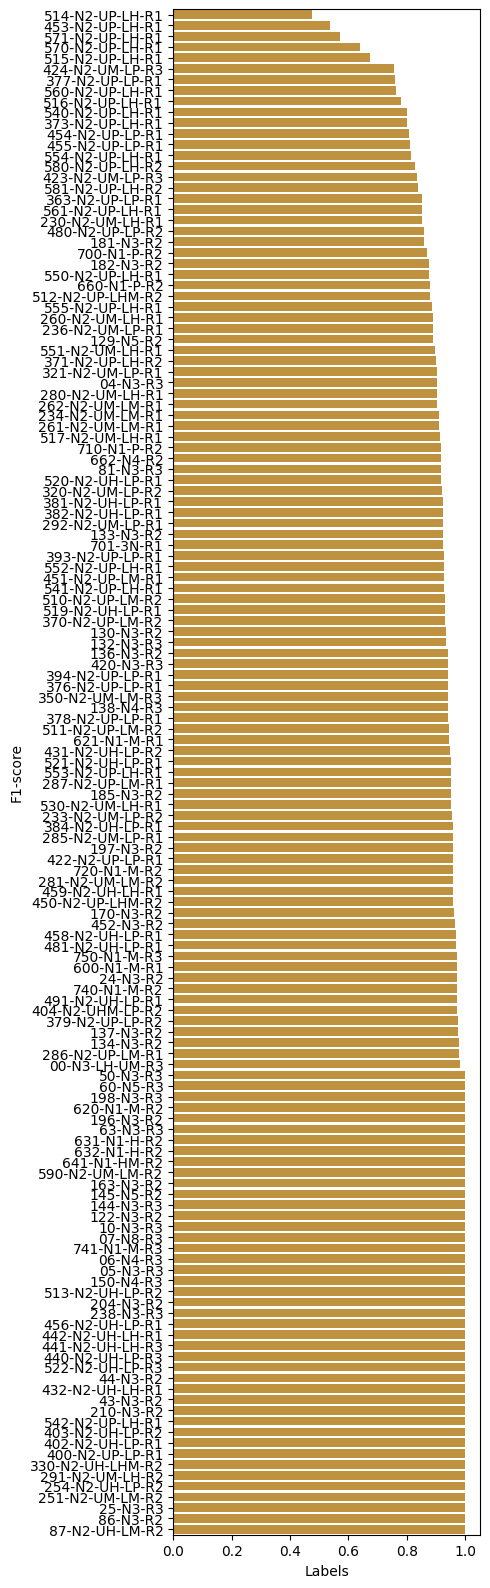

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the f1-scores for the labels to remove
f1_scores = [report[label]['f1-score'] for label in labels_to_keep]

# Create a dictionary with the labels and f1-scores
data = {'Labels': labels_to_keep, 'F1-score': f1_scores}

# Create a pandas DataFrame with the data
df = pd.DataFrame(data)

# Sort the DataFrame by f1-score
df = df.sort_values(by='F1-score')

# Create the bar plot
plt.figure(figsize=(5, 16))
sns.barplot(y='Labels', x='F1-score', data=df, color='orange', saturation=0.5)
plt.xticks(rotation=0)
plt.xlabel('Labels')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig(figures_path/"top_f1.png", dpi=300)

In [129]:
df.head(5).to_csv(data_path / 'top_f1_labels.csv', index=False)

In [ ]:

from scipy.cluster.hierarchy import linkage

# Get the linkage matrix
Z = linkage(conf_mat, "ward")

# Plot the dendrogram on top of the reordered heatmap for the confusion matrix
# using seaborn.clustermap, adding labels from df_cm:

g = sns.clustermap(
    df_cm,
    row_linkage=Z,
    col_linkage=Z,
    row_cluster=True,
    col_cluster=True,
    cmap="magma",
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize": 2},
    yticklabels=True
)

g.cax.set_visible(False)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 3)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 3)
g.savefig(figures_path/"clustered_confusion_matrix.png", dpi=300)


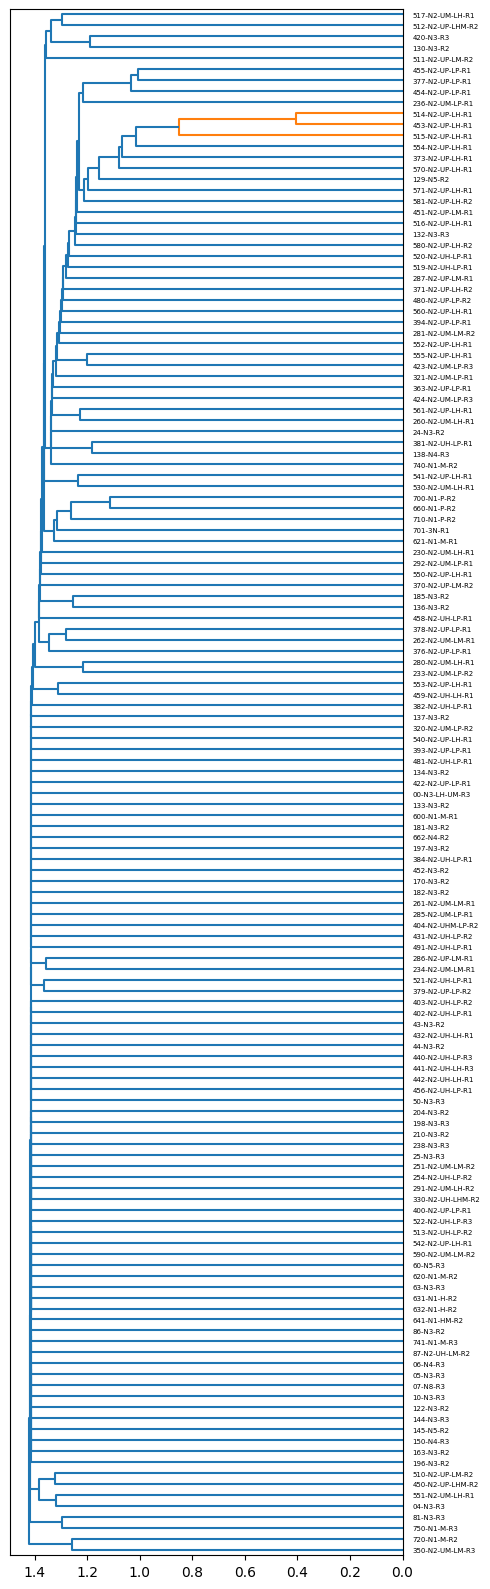

In [134]:
from scipy.cluster.hierarchy import dendrogram, fcluster

# Get the clusters
clusters = fcluster(Z, .2, criterion="distance")

# Plot the dendrogram coloured by cluster
plt.figure(figsize=(5, 16))  # set the figsize to a vertical shape
dendrogram(Z, labels=labels_to_keep, color_threshold=1, orientation='left')  # set the orientation to 'left'
plt.tight_layout()
plt.savefig(figures_path/"classes_tree.png", dpi=300)
plt.show()

array([127,   5,   9,  10,  11,  12,  13,  84, 109,  93, 128, 125,  63,
       120,  72,  14,  15,  16,  17, 135, 130, 136,  64,  18, 132,  32,
        33,  34, 114,  58,  54,  90,  35, 107,  36,  37,  38,  74, 137,
        60,  59, 102, 138,  55,  97,  39, 115, 121, 104,  40,   1, 105,
       117,  98,  82,  62,  87,  61,  52,  73, 119, 133, 123, 101,  41,
        42,  43, 139, 110, 126,  76, 106,  44, 140,  45,  46,  47,  48,
        49,   7,  91, 134,  78,  89,  88,  50, 118,  56,  99, 124, 141,
        51,   8, 113, 111,  22,  79,  80,  92, 112,  96,  95,  53,  23,
        70, 122,  71,  24, 116,   6, 103,  57,  81,  77, 100,  75,  83,
        85,  94,  86,  25,  26, 129,  27,  69,  28,  29,  30,  31,  65,
       131,  66,  68,  67,   2, 108,  19,   3,   4,  20,  21], dtype=int32)